In [1]:
from __future__ import annotations

from pathlib import Path
import re
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


# =============================================================================
# CONFIG
# =============================================================================
INPUT_XLS = Path("data/il bazinda gayrisafi yurt ici hasila iktisadi faaliyet kollarina (a10) gore zincirlenmis hacim endek.xls")
OUTPUT_XLSX = Path("results/gdp_city_contributions.xlsx")

TYPE_FILTER = "Hacim"
SECTOR_CONTAINS = "Gayrisafi"   # senin filtreden
TOTAL_COL = "Türkiye"

# 2023 Kahramanmaraş merkezli depremden etkilenen iller (yaygın liste)
EARTHQUAKE_CITIES = [
    "Kahramanmaraş",
    "Hatay",
    "Gaziantep",
    "Adıyaman",
    "Malatya",
    "Adana",
    "Osmaniye",
    "Kilis",
    "Diyarbakır",
    "Şanlıurfa",
    "Elazığ",
]


# =============================================================================
# Helpers
# =============================================================================
_EN_TAIL_RE = re.compile(r"\s+[A-Z][a-zA-Z ,\-()']+$")


def _clean_tr_label(x: object) -> str:
    """TR\\nEN gibi hücrelerden TR kısmını alır + sonundaki İngilizce kırpıntıları temizler."""
    if pd.isna(x):
        return ""
    s = str(x)
    s = s.split("\n")[0].strip()
    s = _EN_TAIL_RE.sub("", s).strip()
    return s


def read_gdp_raw_xls(path: str | Path) -> pd.DataFrame:
    """Exceli senin mantığınla header/ffill ederek ham tabloya çevirir."""
    df = pd.read_excel(path)
    df = df.dropna(how="all", axis=1).dropna(how="all", axis=0)

    # satır 2 ffill
    if len(df) > 2:
        df.iloc[2] = df.iloc[2].ffill()

    # ilk iki kolon ffill
    if df.shape[1] >= 1:
        df.iloc[:, 0] = df.iloc[:, 0].ffill()
    if df.shape[1] >= 2:
        df.iloc[:, 1] = df.iloc[:, 1].ffill()

    df = df.iloc[2:].copy()

    if len(df) < 2:
        raise ValueError("Beklenen header satırları bulunamadı (df çok kısa).")

    df.columns = df.iloc[0].astype("string") + "--" + df.iloc[1].astype("string")

    # header satırlarını çıkar
    df = df.iloc[2:].copy()
    df = df.dropna(how="all")
    return df


def tidy_gdp_long(df: pd.DataFrame) -> pd.DataFrame:
    """Ham tabloyu long formata (year/area/sector/type/value) çevirir."""
    cols = list(df.columns)
    if len(cols) < 3:
        raise ValueError("İlk 3 kolon bekleniyordu (code/area/year).")

    cols[:3] = ["code", "area", "year"]
    x = df.copy()
    x.columns = cols

    x = x.dropna()
    long = x.melt(id_vars=["code", "area", "year"], var_name="variable", value_name="value")

    parts = long["variable"].astype("string").str.split("--", n=1, expand=True)
    long["sector"] = parts[0].map(_clean_tr_label)
    long["type"] = parts[1].map(_clean_tr_label)

    long = long.drop(columns=["variable", "code"], errors="ignore")
    return long


def build_gdp_wide(long: pd.DataFrame, *, type_filter: str, sector_contains: str) -> pd.DataFrame:
    """Filtre → pivot wide (year x area)."""
    x = long.copy()

    x = x[
        (x["type"] == type_filter)
        & (x["sector"].astype("string").str.contains(sector_contains, na=False))
    ].copy()

    wide = (
        x.pivot_table(
            index="year",
            columns="area",
            values="value",
            aggfunc="sum",
        )
        .sort_index()
    )

    # year index numeric olabiliyorsa dönüştür (sorting iyi olsun)
    try:
        wide.index = pd.to_numeric(wide.index)
        wide = wide.sort_index()
    except Exception:
        pass

    return wide


def compute_city_contributions(gdp_wide: pd.DataFrame, *, total_col: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Türkiye büyümesi ve nominal değişim ile şehir katkılarını hesaplar.
    Dönüş:
      - gdp_wide_with_metrics (Türkiye_growth, Türkiye_nominal_change ekli)
      - city_contribution_percent (şehir kolonları, % katkı)
    """
    df = gdp_wide.copy()

    if total_col not in df.columns:
        raise KeyError(f"'{total_col}' kolonu yok. Kolon örneği: {list(df.columns)[:10]}")

    df["Türkiye_growth"] = df[total_col].pct_change()
    df["Türkiye_nominal_change"] = df[total_col].diff()

    city_cols = [c for c in df.columns if c not in ["Türkiye_growth", "Türkiye_nominal_change"]]

    city_nominal_change = df[city_cols].diff()

    contrib = (
        city_nominal_change
        .div(df["Türkiye_nominal_change"], axis=0)
        .mul(df["Türkiye_growth"], axis=0)
        .replace([float("inf"), float("-inf")], pd.NA)
    )

    # Türkiye'yi şehir katkılarından çıkar (istersen dahil edebilirsin)
    contrib = contrib.drop(columns=[total_col], errors="ignore")

    contrib_percent = contrib.mul(100)
    return df, contrib_percent


def last_year_city_table(city_contribution_percent: pd.DataFrame) -> tuple[int | str, pd.DataFrame]:
    """Son yılın tüm şehir katkılarını 'City/Contribution_percent' tablosu olarak döndürür."""
    last_year = city_contribution_percent.index.max()
    s = city_contribution_percent.loc[last_year].dropna().sort_values(ascending=False)
    out = s.reset_index()
    out.columns = ["City", "Contribution_percent"]
    return last_year, out


def earthquake_summary(
    gdp_with_metrics: pd.DataFrame,
    city_contribution_percent: pd.DataFrame,
    *,
    earthquake_cities: list[str],
    total_col: str,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Son yıl için deprem illeri:
      - iller bazında katkı tablosu
      - toplam katkı (yüzde puan) + Türkiye büyümesi + pay
    """
    last_year = city_contribution_percent.index.max()

    last_contrib = city_contribution_percent.loc[last_year]
    available = [c for c in earthquake_cities if c in last_contrib.index]
    missing = [c for c in earthquake_cities if c not in last_contrib.index]

    eq_table = (
        last_contrib.loc[available]
        .dropna()
        .sort_values(ascending=False)
        .reset_index()
    )
    eq_table.columns = ["City", "Contribution_percent"]

    eq_total = eq_table["Contribution_percent"].sum()

    turkey_growth_percent = float(gdp_with_metrics.loc[last_year, "Türkiye_growth"] * 100)
    eq_share = (eq_total / turkey_growth_percent * 100) if turkey_growth_percent not in (0.0, -0.0) else float("nan")

    summary = pd.DataFrame(
        {
            "metric": [
                "year",
                "earthquake_total_contribution_percent_point",
                "turkey_growth_percent",
                "earthquake_share_of_growth_percent",
                "earthquake_cities_used_count",
                "earthquake_cities_missing_count",
                "earthquake_cities_missing_list",
            ],
            "value": [
                last_year,
                eq_total,
                turkey_growth_percent,
                eq_share,
                len(available),
                len(missing),
                ", ".join(missing),
            ],
        }
    )

    return eq_table, summary


# =============================================================================
# Run
# =============================================================================
def main() -> None:
    OUTPUT_XLSX.parent.mkdir(parents=True, exist_ok=True)

    raw = read_gdp_raw_xls(INPUT_XLS)
    long = tidy_gdp_long(raw)
    gdp_wide = build_gdp_wide(long, type_filter=TYPE_FILTER, sector_contains=SECTOR_CONTAINS)

    gdp_with_metrics, city_contrib_percent = compute_city_contributions(gdp_wide, total_col=TOTAL_COL)

    # Son yıl tüm şehir tablosu
    last_year, city_table = last_year_city_table(city_contrib_percent)

    # Deprem özeti
    eq_table, eq_summary = earthquake_summary(
        gdp_with_metrics=gdp_with_metrics,
        city_contribution_percent=city_contrib_percent,
        earthquake_cities=EARTHQUAKE_CITIES,
        total_col=TOTAL_COL,
    )

    # Export (multi-sheet)
    with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl") as writer:
        gdp_wide.to_excel(writer, sheet_name="gdp_wide")
        gdp_with_metrics.to_excel(writer, sheet_name="gdp_with_metrics")
        city_contrib_percent.to_excel(writer, sheet_name="city_contrib_percent_all_years")

        city_table.to_excel(writer, sheet_name=f"cities_{last_year}", index=False)
        eq_table.to_excel(writer, sheet_name=f"eq_cities_{last_year}", index=False)
        eq_summary.to_excel(writer, sheet_name=f"eq_summary_{last_year}", index=False)

    print("Saved:", OUTPUT_XLSX)
    print("Last year:", last_year)
    print("Earthquake total contribution (pp):", float(eq_summary.loc[eq_summary.metric=="earthquake_total_contribution_percent_point","value"].iloc[0]))


if __name__ == "__main__":
    main()


Saved: results/gdp_city_contributions.xlsx
Last year: 2024
Earthquake total contribution (pp): 0.8942182503772138


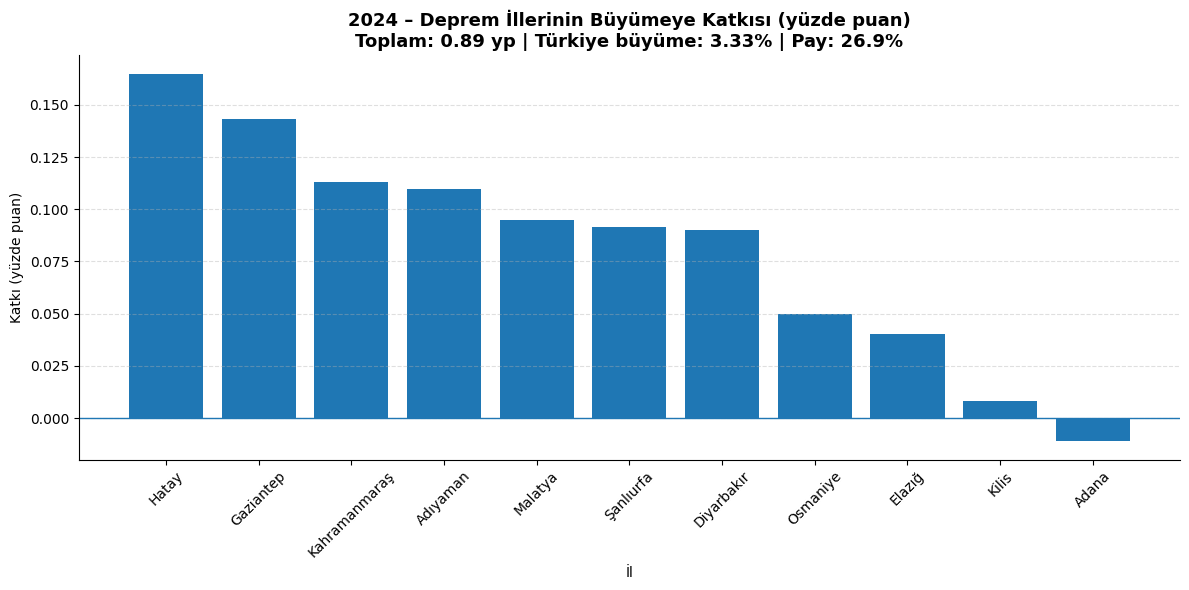

Saved: results/gdp_city_contributions.xlsx
Saved figure: results/eq_cities_contribution_2024.png
Last year: 2024
Earthquake total contribution (pp): 0.8942182503772138


In [3]:
from __future__ import annotations

from pathlib import Path
import re
import warnings

import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


# =============================================================================
# CONFIG
# =============================================================================
INPUT_XLS = Path(
    "data/il bazinda gayrisafi yurt ici hasila iktisadi faaliyet kollarina (a10) gore zincirlenmis hacim endek.xls"
)
OUTPUT_XLSX = Path("results/gdp_city_contributions.xlsx")

TYPE_FILTER = "Hacim"
SECTOR_CONTAINS = "Gayrisafi"   # senin filtreden
TOTAL_COL = "Türkiye"

# 2023 Kahramanmaraş merkezli depremden etkilenen iller (yaygın liste)
EARTHQUAKE_CITIES = [
    "Kahramanmaraş",
    "Hatay",
    "Gaziantep",
    "Adıyaman",
    "Malatya",
    "Adana",
    "Osmaniye",
    "Kilis",
    "Diyarbakır",
    "Şanlıurfa",
    "Elazığ",
]


# =============================================================================
# Helpers
# =============================================================================
_EN_TAIL_RE = re.compile(r"\s+[A-Z][a-zA-Z ,\-()']+$")


def _clean_tr_label(x: object) -> str:
    """TR\\nEN gibi hücrelerden TR kısmını alır + sonundaki İngilizce kırpıntıları temizler."""
    if pd.isna(x):
        return ""
    s = str(x)
    s = s.split("\n")[0].strip()
    s = _EN_TAIL_RE.sub("", s).strip()
    return s


def read_gdp_raw_xls(path: str | Path) -> pd.DataFrame:
    """Exceli senin mantığınla header/ffill ederek ham tabloya çevirir."""
    df = pd.read_excel(path)
    df = df.dropna(how="all", axis=1).dropna(how="all", axis=0)

    # satır 2 ffill
    if len(df) > 2:
        df.iloc[2] = df.iloc[2].ffill()

    # ilk iki kolon ffill
    if df.shape[1] >= 1:
        df.iloc[:, 0] = df.iloc[:, 0].ffill()
    if df.shape[1] >= 2:
        df.iloc[:, 1] = df.iloc[:, 1].ffill()

    df = df.iloc[2:].copy()

    if len(df) < 2:
        raise ValueError("Beklenen header satırları bulunamadı (df çok kısa).")

    df.columns = df.iloc[0].astype("string") + "--" + df.iloc[1].astype("string")

    # header satırlarını çıkar
    df = df.iloc[2:].copy()
    df = df.dropna(how="all")
    return df


def tidy_gdp_long(df: pd.DataFrame) -> pd.DataFrame:
    """Ham tabloyu long formata (year/area/sector/type/value) çevirir."""
    cols = list(df.columns)
    if len(cols) < 3:
        raise ValueError("İlk 3 kolon bekleniyordu (code/area/year).")

    cols[:3] = ["code", "area", "year"]
    x = df.copy()
    x.columns = cols

    x = x.dropna()
    long = x.melt(id_vars=["code", "area", "year"], var_name="variable", value_name="value")

    parts = long["variable"].astype("string").str.split("--", n=1, expand=True)
    long["sector"] = parts[0].map(_clean_tr_label)
    long["type"] = parts[1].map(_clean_tr_label)

    long = long.drop(columns=["variable", "code"], errors="ignore")
    return long


def build_gdp_wide(long: pd.DataFrame, *, type_filter: str, sector_contains: str) -> pd.DataFrame:
    """Filtre → pivot wide (year x area)."""
    x = long.copy()

    x = x[
        (x["type"] == type_filter)
        & (x["sector"].astype("string").str.contains(sector_contains, na=False))
    ].copy()

    wide = (
        x.pivot_table(
            index="year",
            columns="area",
            values="value",
            aggfunc="sum",
        )
        .sort_index()
    )

    # year index numeric olabiliyorsa dönüştür (sorting iyi olsun)
    try:
        wide.index = pd.to_numeric(wide.index)
        wide = wide.sort_index()
    except Exception:
        pass

    return wide


def compute_city_contributions(gdp_wide: pd.DataFrame, *, total_col: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Türkiye büyümesi ve nominal değişim ile şehir katkılarını hesaplar.
    Dönüş:
      - gdp_wide_with_metrics (Türkiye_growth, Türkiye_nominal_change ekli)
      - city_contribution_percent (şehir kolonları, % katkı = yüzde puan)
    """
    df = gdp_wide.copy()

    if total_col not in df.columns:
        raise KeyError(f"'{total_col}' kolonu yok. Kolon örneği: {list(df.columns)[:10]}")

    df["Türkiye_growth"] = df[total_col].pct_change()
    df["Türkiye_nominal_change"] = df[total_col].diff()

    city_cols = [c for c in df.columns if c not in ["Türkiye_growth", "Türkiye_nominal_change"]]

    city_nominal_change = df[city_cols].diff()

    contrib = (
        city_nominal_change
        .div(df["Türkiye_nominal_change"], axis=0)
        .mul(df["Türkiye_growth"], axis=0)
        .replace([float("inf"), float("-inf")], pd.NA)
    )

    # Türkiye'yi şehir katkılarından çıkar (istersen dahil edebilirsin)
    contrib = contrib.drop(columns=[total_col], errors="ignore")

    contrib_percent = contrib.mul(100)  # yüzde puan
    return df, contrib_percent


def last_year_city_table(city_contribution_percent: pd.DataFrame) -> tuple[int | str, pd.DataFrame]:
    """Son yılın tüm şehir katkılarını 'City/Contribution_percent' tablosu olarak döndürür."""
    last_year = city_contribution_percent.index.max()
    s = city_contribution_percent.loc[last_year].dropna().sort_values(ascending=False)
    out = s.reset_index()
    out.columns = ["City", "Contribution_percent"]
    return last_year, out


def earthquake_summary(
    gdp_with_metrics: pd.DataFrame,
    city_contribution_percent: pd.DataFrame,
    *,
    earthquake_cities: list[str],
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Son yıl için deprem illeri:
      - iller bazında katkı tablosu
      - toplam katkı (yüzde puan) + Türkiye büyümesi + pay
    """
    last_year = city_contribution_percent.index.max()

    last_contrib = city_contribution_percent.loc[last_year]
    available = [c for c in earthquake_cities if c in last_contrib.index]
    missing = [c for c in earthquake_cities if c not in last_contrib.index]

    eq_table = (
        last_contrib.loc[available]
        .dropna()
        .sort_values(ascending=False)
        .reset_index()
    )
    eq_table.columns = ["City", "Contribution_percent"]

    eq_total = float(eq_table["Contribution_percent"].sum())

    turkey_growth_percent = float(gdp_with_metrics.loc[last_year, "Türkiye_growth"] * 100)
    eq_share = (eq_total / turkey_growth_percent * 100) if turkey_growth_percent not in (0.0, -0.0) else float("nan")

    summary = pd.DataFrame(
        {
            "metric": [
                "year",
                "earthquake_total_contribution_percent_point",
                "turkey_growth_percent",
                "earthquake_share_of_growth_percent",
                "earthquake_cities_used_count",
                "earthquake_cities_missing_count",
                "earthquake_cities_missing_list",
            ],
            "value": [
                last_year,
                eq_total,
                turkey_growth_percent,
                eq_share,
                len(available),
                len(missing),
                ", ".join(missing),
            ],
        }
    )

    return eq_table, summary


def plot_earthquake_city_contributions(
    city_contribution_percent: pd.DataFrame,
    gdp_with_metrics: pd.DataFrame,
    *,
    earthquake_cities: list[str],
    out_dir: Path,
    top_n: int | None = None,   # None => hepsini çiz
) -> Path:
    """
    Son yıl deprem illeri katkılarını bar chart olarak çizer ve kaydeder.
    Değerler: yüzde puan (city_contribution_percent zaten *100).
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    last_year = city_contribution_percent.index.max()
    s = city_contribution_percent.loc[last_year]

    available = [c for c in earthquake_cities if c in s.index]
    missing = [c for c in earthquake_cities if c not in s.index]

    eq_series = (
        s.loc[available]
        .dropna()
        .sort_values(ascending=False)
    )

    if top_n is not None:
        eq_series = eq_series.head(top_n)

    eq_total_pp = float(eq_series.sum())
    turkey_growth_pct = float(gdp_with_metrics.loc[last_year, "Türkiye_growth"] * 100)
    eq_share = (eq_total_pp / turkey_growth_pct * 100) if turkey_growth_pct not in (0.0, -0.0) else float("nan")

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(eq_series.index, eq_series.values)

    ax.axhline(0, linewidth=1)
    ax.set_title(
        f"{last_year} – Deprem İllerinin Büyümeye Katkısı (yüzde puan)\n"
        f"Toplam: {eq_total_pp:.2f} yp | Türkiye büyüme: {turkey_growth_pct:.2f}% | Pay: {eq_share:.1f}%",
        fontsize=13,
        fontweight="bold",
    )
    ax.set_ylabel("Katkı (yüzde puan)")
    ax.set_xlabel("İl")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()

    out_path = out_dir / f"eq_cities_contribution_{last_year}.png"
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()

    if missing:
        print("⚠️ Deprem listesinde olup veride bulunmayan iller:", missing)

    return out_path


# =============================================================================
# Run
# =============================================================================
def main() -> None:
    OUTPUT_XLSX.parent.mkdir(parents=True, exist_ok=True)

    raw = read_gdp_raw_xls(INPUT_XLS)
    long = tidy_gdp_long(raw)
    gdp_wide = build_gdp_wide(long, type_filter=TYPE_FILTER, sector_contains=SECTOR_CONTAINS)

    gdp_with_metrics, city_contrib_percent = compute_city_contributions(gdp_wide, total_col=TOTAL_COL)

    # Son yıl tüm şehir tablosu
    last_year, city_table = last_year_city_table(city_contrib_percent)

    # Deprem özeti
    eq_table, eq_summary = earthquake_summary(
        gdp_with_metrics=gdp_with_metrics,
        city_contribution_percent=city_contrib_percent,
        earthquake_cities=EARTHQUAKE_CITIES,
    )

    # Deprem illeri katkı grafiği (PNG)
    fig_path = plot_earthquake_city_contributions(
        city_contribution_percent=city_contrib_percent,
        gdp_with_metrics=gdp_with_metrics,
        earthquake_cities=EARTHQUAKE_CITIES,
        out_dir=Path("results"),
        top_n=None,  # istersen 10 yap
    )

    # Export (multi-sheet)
    with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl") as writer:
        gdp_wide.to_excel(writer, sheet_name="gdp_wide")
        gdp_with_metrics.to_excel(writer, sheet_name="gdp_with_metrics")
        city_contrib_percent.to_excel(writer, sheet_name="city_contrib_percent_all_years")

        city_table.to_excel(writer, sheet_name=f"cities_{last_year}", index=False)
        eq_table.to_excel(writer, sheet_name=f"eq_cities_{last_year}", index=False)
        eq_summary.to_excel(writer, sheet_name=f"eq_summary_{last_year}", index=False)

    print("Saved:", OUTPUT_XLSX)
    print("Saved figure:", fig_path)
    print("Last year:", last_year)
    print(
        "Earthquake total contribution (pp):",
        float(
            eq_summary.loc[
                eq_summary.metric == "earthquake_total_contribution_percent_point",
                "value",
            ].iloc[0]
        ),
    )


if __name__ == "__main__":
    main()
